In [1]:
# Install YOLOv8 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 20.3 MB/s eta 0:00:00


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# Define paths
root_dir = '/kaggle/input/welding-defect-object-detection'
v1_dir = os.path.join(root_dir, 'The Welding Defect Dataset/The Welding Defect Dataset')
v2_dir = os.path.join(root_dir, 'The Welding Defect Dataset - v2/The Welding Defect Dataset - v2')

In [4]:
# Ensure the YOLOv8 data directories exist
os.makedirs('yolov8/data/welding_v1', exist_ok=True)
os.makedirs('yolov8/data/welding_v2', exist_ok=True)

Displaying some training images from version 1:


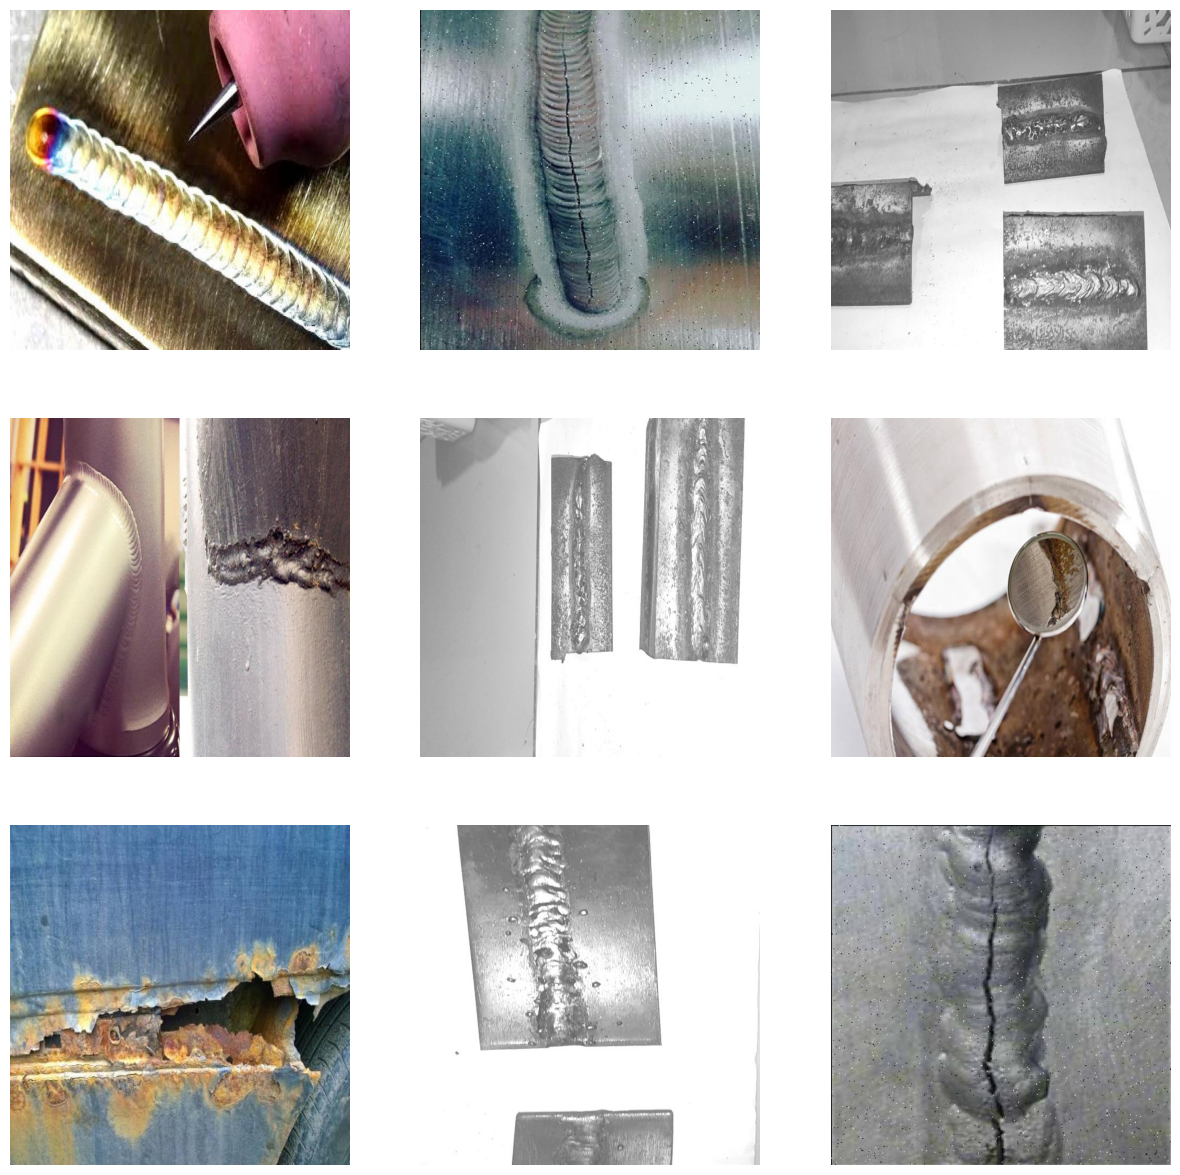

Displaying some training images from version 2:


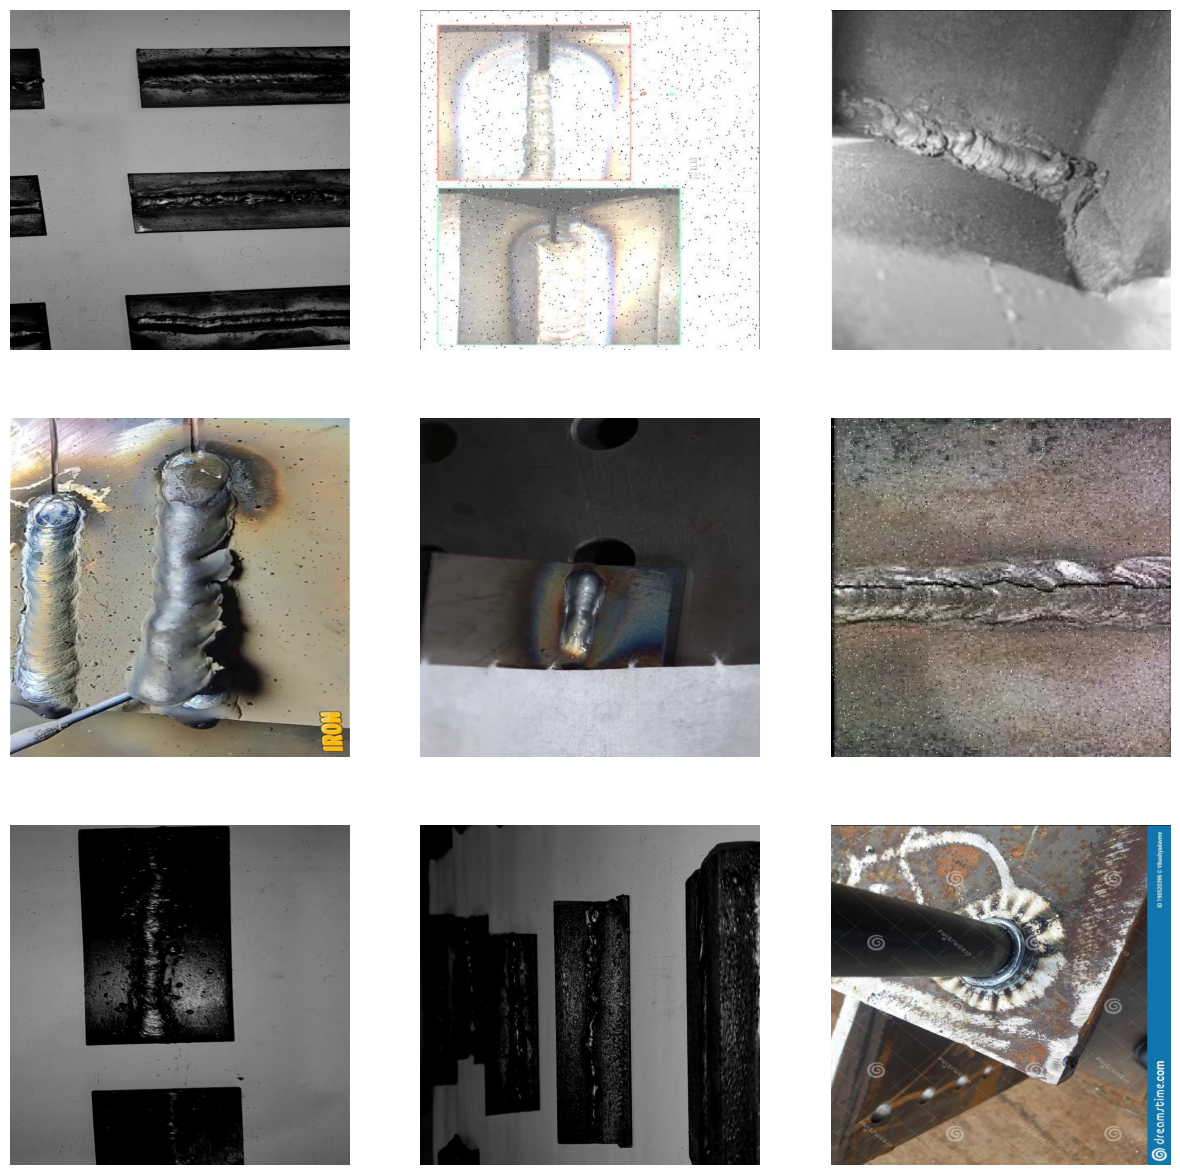

In [5]:
# Function to display images
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

print("Displaying some training images from version 2:")
display_images(os.path.join(v2_dir, 'train/images'))

In [6]:
# Copy dataset to YOLOv8 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov8/data/welding_v1')

# Copy version 2 dataset
copy_dataset_to_yolo(v2_dir, 'yolov8/data/welding_v2')

In [7]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov8/data/welding_v1/data.yaml', '/kaggle/working/yolov8/data/welding_v1')

# Update data.yaml for version 2
update_data_yaml('yolov8/data/welding_v2/data.yaml', '/kaggle/working/yolov8/data/welding_v2')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov8/data/welding_v1/data.yaml')

print("Updated data.yaml for version 2:")
print_data_yaml('yolov8/data/welding_v2/data.yaml')

Updated data.yaml for version 1:
train: /kaggle/working/yolov8/data/welding_v1/train/images
val: /kaggle/working/yolov8/data/welding_v1/valid/images
test: /kaggle/working/yolov8/data/welding_v1/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']


Updated data.yaml for version 2:
train: /kaggle/working/yolov8/data/welding_v2/train/images
val: /kaggle/working/yolov8/data/welding_v2/valid/images
test: /kaggle/working/yolov8/data/welding_v2/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']




In [8]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

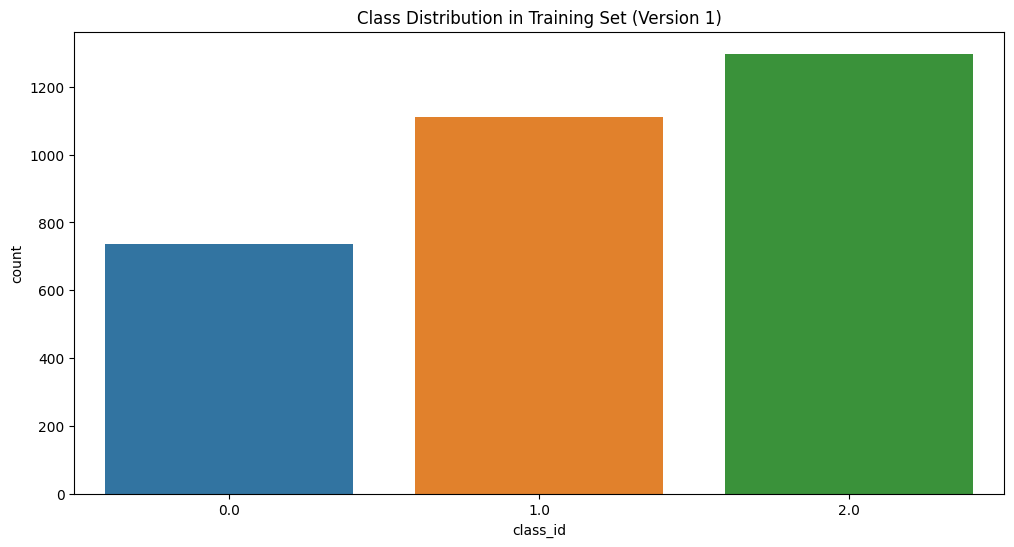

In [9]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

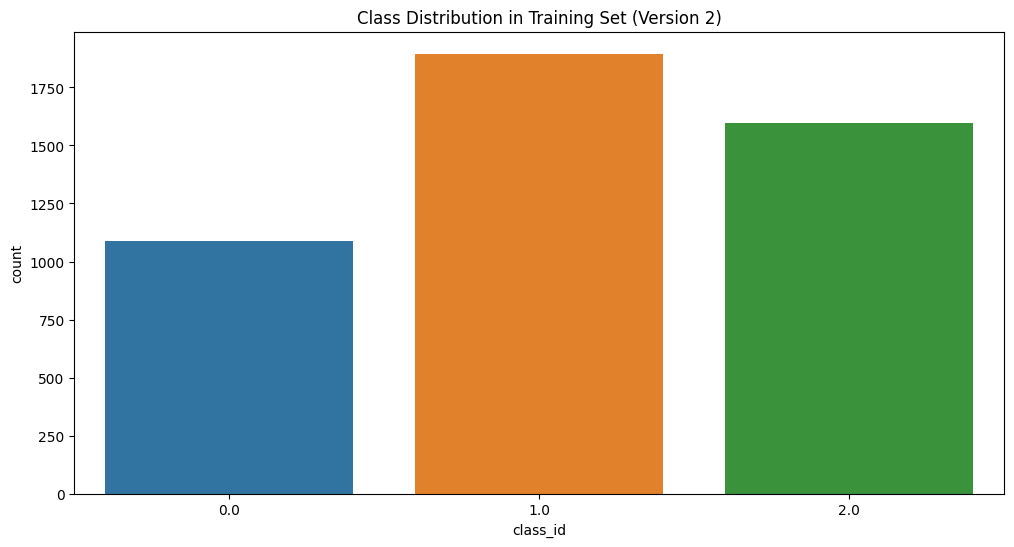

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=v2_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 2)')
plt.show()

In [11]:
# Train YOLOv8 model with augmentation and hyperparameter tuning
# Initialize model
model_v1 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model
model_v2 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model

100%|██████████| 49.7M/49.7M [00:00<00:00, 275MB/s]


In [12]:
# Train model on version 1 dataset
model_v1.train(data='/kaggle/working/yolov8/data/welding_v1/data.yaml', epochs=100, imgsz=640, batch=16, name='welding_v1_aug', 
               lr0=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
               box=0.05, cls=0.5, iou=0.2, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=1.0, mixup=0.5)

# Train model on version 2 dataset
model_v2.train(data='/kaggle/working/yolov8/data/welding_v2/data.yaml', epochs=100, imgsz=640, batch=16, name='welding_v2_aug', 
               lr0=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
               box=0.05, cls=0.5, iou=0.2, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=1.0, mixup=0.5)

Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolov8/data/welding_v1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

100%|██████████| 755k/755k [00:00<00:00, 21.8MB/s]
2024-07-14 19:41:17,787	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-14 19:41:18,615	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Currently logged in as: faf2001f (faf2001f-university-of-engineering-and-technology-taxila). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240714_194131-b2pbywmz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run welding_v1_aug
wandb: ⭐️ View project at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8
wandb: 🚀 View run at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8/runs/b2pbywmz


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 122MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolov8/data/welding_v1/train/labels... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<00:00, 1245.76it/s]


train: New cache created: /kaggle/working/yolov8/data/welding_v1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolov8/data/welding_v1/valid/labels... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 1150.60it/s]

val: New cache created: /kaggle/working/yolov8/data/welding_v1/valid/labels.cache


Plotting labels to runs/detect/welding_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/welding_v1_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.21G    0.01468      2.831      1.894         37        640: 100%|██████████| 53/53 [00:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        176        573      0.161      0.326      0.156     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         7G    0.01388      2.382      1.795         76        640: 100%|██████████| 53/53 [00:24<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        176        573      0.323       0.17      0.101     0.0371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.02G    0.01411      2.385      1.849         68        640: 100%|██████████| 53/53 [00:24<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573      0.345      0.276      0.213     0.0865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.12G    0.01404      2.341       1.86         76        640: 100%|██████████| 53/53 [00:24<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        176        573      0.229      0.273      0.164     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       7.1G    0.01364      2.325      1.795         51        640: 100%|██████████| 53/53 [00:25<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        176        573      0.369      0.376      0.275      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.03G     0.0136      2.268      1.824         54        640: 100%|██████████| 53/53 [00:25<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        176        573       0.39      0.309      0.269      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.11G    0.01351      2.245      1.794         49        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        176        573      0.335      0.371      0.306      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.09G    0.01304      2.173      1.737         59        640: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        176        573      0.388      0.404      0.302      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.16G     0.0129       2.15      1.733         55        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        176        573      0.305      0.476      0.273      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.05G    0.01272       2.16        1.7         48        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        176        573      0.458      0.449      0.355      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.15G    0.01247       2.07      1.692         47        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        176        573      0.351      0.447      0.335      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.16G    0.01265      2.074      1.715         70        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.407      0.493      0.377      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.15G     0.0124      2.028      1.674         88        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        176        573      0.374      0.484      0.368      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.01G    0.01227       1.98      1.651         43        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.385        0.5      0.366      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.15G    0.01213      1.966      1.645         59        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.413      0.566       0.43      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.15G    0.01195      1.924       1.63         90        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.472      0.497      0.435      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.16G    0.01184      1.891      1.621         80        640: 100%|██████████| 53/53 [00:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573       0.41      0.528      0.384      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         7G    0.01181      1.892      1.631         51        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        176        573      0.385       0.52      0.384      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.13G     0.0119      1.903      1.637         47        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.434      0.553      0.404      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.15G    0.01152      1.835      1.598         48        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573      0.445       0.54      0.424       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.15G    0.01151      1.815       1.59         65        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.493      0.549      0.458      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.04G    0.01145      1.757      1.567         56        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.471      0.563      0.476      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.15G     0.0112      1.751      1.552         33        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573      0.453      0.527      0.432      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.15G    0.01127       1.74      1.543         66        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573       0.48      0.552      0.451      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.13G    0.01132      1.703      1.545         76        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573      0.472      0.523      0.438       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         7G    0.01097      1.679      1.517         76        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.517      0.577      0.504      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.15G    0.01086      1.639      1.502         80        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573       0.49      0.573      0.456      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.11G    0.01096      1.659      1.518         49        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.517      0.504      0.475       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.13G    0.01097       1.64      1.518         58        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        176        573      0.497      0.503      0.432      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.02G     0.0109      1.627      1.515         39        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.521      0.544      0.475       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.17G    0.01082      1.619      1.507        100        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.507      0.562       0.48      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.14G     0.0107      1.616      1.485         82        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.514      0.568      0.534      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.11G    0.01081      1.601      1.504         54        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        176        573      0.535      0.548      0.476      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.08G    0.01052      1.537      1.488         49        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.544      0.574      0.527      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.17G    0.01065      1.569       1.49         62        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.539      0.577      0.521      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.14G    0.01055      1.529      1.472         66        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.568      0.567      0.529      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       7.1G    0.01045      1.508      1.464         91        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.526      0.591      0.523       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.03G    0.01043       1.52      1.469         44        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.493      0.569      0.488      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.14G    0.01033      1.506      1.458         70        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.556      0.562      0.528       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.16G    0.01023      1.482      1.437         65        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.562      0.579      0.558      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.09G    0.01042      1.511      1.469         44        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.521      0.588      0.532      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.04G     0.0103      1.454      1.462         49        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.609       0.55       0.57      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.11G    0.01011      1.471      1.448         68        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.617       0.59      0.579       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       7.1G    0.01013      1.418      1.424         55        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.608      0.588      0.577      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.14G     0.0103      1.442      1.453         56        640: 100%|██████████| 53/53 [00:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.636      0.565      0.559      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.05G    0.01007      1.401      1.419         61        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.573      0.545      0.531      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.14G   0.009995      1.387      1.412         74        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.607      0.569      0.566      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.15G   0.009744      1.327      1.389         71        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.588       0.61      0.573      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.14G   0.009875      1.345      1.394         44        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573      0.548      0.567      0.536      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.06G   0.009892       1.35      1.417         58        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.601      0.577      0.554      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.14G   0.009561      1.288      1.381         45        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.587      0.607      0.587      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.14G   0.009696      1.326      1.408         53        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.583      0.588      0.567      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.13G    0.00979      1.337      1.388         65        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.613      0.595      0.588      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.06G    0.00984      1.322      1.406         58        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.589      0.585      0.571       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.15G   0.009691       1.31      1.399         61        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.589      0.614      0.584      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.16G   0.009594      1.307      1.386         45        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.546      0.637      0.589      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.17G   0.009572      1.266      1.376         54        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        176        573      0.584      0.622        0.6      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.04G   0.009577       1.28      1.382         46        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.624      0.604      0.596      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.14G   0.009484      1.254      1.367         40        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573       0.64      0.592      0.592      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.13G   0.009439       1.28      1.381         42        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.588      0.601      0.581      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.16G   0.009349      1.226      1.361         36        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.637       0.62      0.622      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.05G   0.009305      1.208      1.347         67        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.643        0.6      0.601      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.13G   0.009189      1.194      1.343         53        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.642      0.622      0.625      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.14G   0.009314      1.214      1.355         55        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        176        573      0.639      0.627      0.622      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.14G   0.009182      1.205      1.358         48        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.606      0.641      0.612      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.04G   0.009223      1.192      1.356         58        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.592      0.667      0.622      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.12G   0.009129      1.159      1.325         42        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.657      0.627      0.627      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.12G   0.009034      1.181      1.332         61        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.612       0.66      0.628      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.16G   0.008975      1.168       1.33         44        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.669      0.601      0.624      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.05G   0.009016      1.126      1.315         50        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.632      0.611      0.618      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.16G   0.009006      1.145      1.326         69        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.609       0.64      0.616      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.19G   0.008997      1.144      1.309         59        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.594      0.602      0.582      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.13G    0.00893      1.126      1.323         54        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.679      0.582      0.626      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.05G   0.008737      1.116      1.301         73        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.642      0.618      0.628      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.11G   0.008709       1.09        1.3         73        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.628      0.623      0.617      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.14G   0.008691      1.099      1.307         51        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        176        573      0.642      0.603      0.609      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.11G   0.008768        1.1      1.298         88        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        176        573      0.581       0.64      0.608      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.99G   0.008618      1.068      1.293         41        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.648      0.654      0.644      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.14G   0.008755      1.094      1.294         73        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.631       0.63      0.613      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.12G    0.00863      1.055      1.282         78        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573      0.664       0.59      0.606      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.15G   0.008598      1.058      1.285         45        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.681      0.591      0.632      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.04G   0.008522      1.041      1.272         40        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.668      0.636      0.648      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.18G   0.008497       1.05      1.279         45        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.694      0.628      0.642      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.16G   0.008405      1.028      1.272         55        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.683      0.634      0.639      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.14G   0.008429      1.018      1.274         57        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.662      0.634      0.643       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.06G   0.008327      1.009      1.259         64        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.664      0.644      0.647      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.14G   0.008245     0.9851      1.252         68        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.674      0.654      0.651      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.17G   0.008269     0.9796       1.26         67        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.661      0.617      0.638      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.15G   0.008319      1.001      1.259         74        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        176        573      0.685      0.644      0.648      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.04G   0.008253     0.9858      1.248         57        640: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.627       0.65      0.635      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.08G   0.007051     0.7912      1.176         34        640: 100%|██████████| 53/53 [00:26<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.674      0.626      0.641      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.08G   0.006953     0.7393      1.156         18        640: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.653      0.652      0.653      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.08G   0.006747     0.7156      1.148          8        640: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.628      0.643      0.643       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.03G   0.006729      0.707      1.132         19        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        176        573      0.651      0.638       0.65      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.11G   0.006635     0.6834      1.131         33        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        573       0.65      0.656      0.656      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.09G   0.006613     0.6662      1.116         36        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.651      0.642      0.653      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.12G   0.006445     0.6538       1.11         32        640: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.636      0.672      0.653      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.99G   0.006277     0.6477       1.11         23        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        176        573      0.664      0.658      0.653      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.09G   0.006269     0.6346      1.107         29        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        176        573      0.677      0.642       0.66      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.09G   0.006341     0.6323      1.106         25        640: 100%|██████████| 53/53 [00:25<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        176        573      0.696      0.639       0.67      0.395



100 epochs completed in 0.823 hours.
Optimizer stripped from runs/detect/welding_v1_aug/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/welding_v1_aug/weights/best.pt, 52.0MB

Validating runs/detect/welding_v1_aug/weights/best.pt...
Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


                   all        176        573      0.686      0.642      0.673      0.396
              Bad Weld         87        127      0.695      0.772      0.771      0.491
             Good Weld        119        253      0.745      0.715      0.747       0.49
                Defect         90        193      0.618       0.44      0.501      0.205
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/welding_v1_aug


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▂▃▃▃▄▅▄▅▅▆▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:     metrics/mAP50-95(B) ▁▁▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇██████
wandb:    metrics/precision(B) ▁▃▄▄▄▄▅▄▅▅▆▆▆▆▆▆▆▇▆▆▇▇▆▇▇▇██▇▇▇▇██████▇█
wandb:       metrics/recall(B) ▂▁▂▃▄▅▅▅▆▅▆▅▆▆▆▆▇▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁
wandb:          train/cls_loss █▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
wandb:          train/dfl_loss ██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▇█▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁

Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolov8/data/welding_v2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v2_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240714_203145-omdk33n1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run welding_v2_aug
wandb: ⭐️ View project at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8
wandb: 🚀 View run at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8/runs/omdk33n1


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/yolov8/data/welding_v2/train/labels... 1619 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1619/1619 [00:01<00:00, 1299.21it/s]

train: New cache created: /kaggle/working/yolov8/data/welding_v2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolov8/data/welding_v2/valid/labels... 283 images, 0 backgrounds, 0 corrupt: 100%|██████████| 283/283 [00:00<00:00, 1413.13it/s]

val: New cache created: /kaggle/working/yolov8/data/welding_v2/valid/labels.cache


Plotting labels to runs/detect/welding_v2_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/welding_v2_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.72G    0.01413      2.728      1.896         31        640: 100%|██████████| 102/102 [00:52<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all        283        802     0.0831      0.367     0.0508     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.69G    0.01457      2.565      1.979         29        640: 100%|██████████| 102/102 [00:49<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

                   all        283        802      0.211      0.225      0.133     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.59G    0.01452      2.578      1.984         15        640: 100%|██████████| 102/102 [00:49<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]

                   all        283        802      0.545      0.245       0.16     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.66G    0.01425      2.541      1.985         13        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]

                   all        283        802      0.318      0.268      0.208     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.71G    0.01388      2.468      1.964         16        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

                   all        283        802      0.284      0.297      0.207     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.67G    0.01355      2.439      1.938         22        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

                   all        283        802      0.313      0.342      0.225      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.74G    0.01333      2.392      1.894         25        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.422      0.365      0.311      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.65G    0.01316      2.326      1.853         28        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.392      0.394      0.305      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.73G    0.01297      2.268      1.845         43        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.327      0.411       0.27      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.64G     0.0128      2.241      1.826         11        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.452      0.447      0.387      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.73G    0.01259      2.175      1.804         13        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.387      0.425      0.341       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.64G    0.01254      2.163      1.802         15        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

                   all        283        802      0.406      0.448      0.361      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.67G    0.01245      2.113      1.789         20        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.317      0.409      0.357      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.65G    0.01206      2.071      1.748         19        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

                   all        283        802      0.483      0.514      0.436      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.67G    0.01209       2.04       1.76         18        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.419      0.483      0.388      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.67G    0.01207      2.007       1.74          6        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.545      0.562      0.483      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.72G     0.0119      1.981      1.719         20        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.485      0.517      0.441      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.65G    0.01182      1.958      1.704         23        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.455      0.503      0.416      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       7.7G    0.01187      1.972      1.723         16        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.528      0.551      0.477      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.68G    0.01172      1.934      1.706         11        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.448       0.54      0.421      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.68G     0.0117      1.899      1.685         21        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.482      0.576      0.492      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.67G    0.01152      1.875      1.674         10        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.507      0.534      0.472      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.7G    0.01152      1.872      1.677         27        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.581      0.579      0.562      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.67G    0.01136      1.838      1.655         18        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.502       0.57      0.477      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.69G    0.01136      1.795      1.639         21        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.604      0.553      0.547      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.65G     0.0114      1.815      1.648         17        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.531      0.592      0.516      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.73G    0.01136      1.787      1.648         16        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.513       0.57      0.495      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.66G    0.01123      1.774      1.649         17        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.578        0.6      0.541      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.71G     0.0111      1.742      1.631         10        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.523       0.61      0.547       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.64G    0.01089      1.694      1.598         29        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.587      0.615      0.574      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       7.7G    0.01095      1.697      1.609         23        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.621      0.576      0.583      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.68G    0.01102       1.68      1.609          8        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.583      0.609      0.575      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       7.7G    0.01082      1.672      1.597         17        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.566      0.652      0.603      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.64G    0.01081      1.668      1.607         23        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.544      0.649      0.585      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.68G    0.01081      1.652      1.591         45        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.529      0.612      0.546      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.67G    0.01062      1.625       1.58         14        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.551      0.643      0.587      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.69G    0.01072      1.624      1.589         26        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802       0.56      0.663      0.596      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.65G    0.01063      1.597       1.58         15        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.596      0.619      0.597      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.69G    0.01049      1.584      1.569         21        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.584      0.618      0.604      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.66G     0.0105      1.563      1.571         18        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.583      0.616        0.6      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.71G    0.01038      1.534      1.557         13        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.598      0.626      0.601      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.65G    0.01027      1.505      1.538         28        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.639      0.582      0.602      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.71G    0.01024      1.499      1.538          9        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.633      0.636      0.629       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.64G    0.01026      1.502      1.532         13        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.601      0.645      0.615       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.69G    0.01026      1.465      1.527         12        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.637      0.617      0.637      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.65G    0.01026       1.49      1.543          9        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.583      0.683      0.651      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.75G    0.01014      1.459      1.529         19        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.659      0.619       0.65      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.69G    0.01008      1.423      1.501         11        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.627      0.658      0.654      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.72G       0.01      1.416      1.504         22        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.613      0.659      0.646      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.65G     0.0101      1.425      1.519         26        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.619      0.653      0.649      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.68G     0.0101      1.418      1.512         26        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.619      0.681      0.667       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.65G   0.009944      1.402      1.509         25        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.677       0.66      0.673        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.67G   0.009984       1.39      1.499         13        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.677      0.662      0.669      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.69G   0.009788      1.381      1.498         17        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.664      0.627      0.666      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       7.7G     0.0098      1.383      1.497         15        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.635      0.706      0.681      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.66G    0.00967      1.324      1.476         18        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.701      0.652      0.679      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.69G   0.009751      1.346      1.489         13        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

                   all        283        802      0.646      0.693      0.684      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.64G   0.009618      1.313      1.474         26        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.682      0.662      0.688      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.68G   0.009661      1.319      1.464         19        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.708      0.652      0.685       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.68G   0.009502      1.293      1.451          9        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.696      0.676      0.691       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       7.7G   0.009455      1.278      1.459         20        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.657      0.685      0.686      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.72G   0.009515      1.281      1.457         27        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.634      0.722      0.695      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       7.7G   0.009435      1.269      1.444         22        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.664       0.71      0.711      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.68G   0.009391      1.263      1.449         22        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.745      0.661      0.715      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.68G   0.009263       1.24      1.431         13        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.685      0.675      0.706       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.7G    0.00925      1.238      1.428         17        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802        0.7      0.681       0.72      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.71G   0.009295      1.238       1.43         31        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.684       0.71      0.717      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.67G    0.00919      1.216      1.421         23        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.713      0.678      0.699      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.7G    0.00907      1.194       1.41         24        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.711      0.662      0.716      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.63G   0.009064       1.18      1.414         10        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.685      0.701      0.721      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.75G   0.009046      1.169      1.413         16        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.759      0.657      0.714      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.69G   0.009109      1.196      1.421         18        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.749      0.663      0.729      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.71G   0.008989      1.161      1.403         25        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.738      0.677      0.725      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       7.7G   0.008796      1.129      1.381         25        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802       0.68      0.724      0.722      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.68G   0.008935       1.16      1.393         27        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.728      0.713      0.739      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.68G   0.008795      1.142      1.376         32        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.743      0.721      0.742      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.68G   0.008863      1.138      1.403         30        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.742      0.699      0.745      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.66G   0.008744      1.113      1.385         17        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.726      0.726      0.742      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.71G    0.00876      1.104      1.363         28        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.757      0.698      0.743      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       7.7G   0.008606      1.087      1.356         22        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.771      0.674      0.731      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.71G   0.008698      1.091      1.366         14        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.722      0.726      0.744      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.67G   0.008564      1.067      1.353         12        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.739      0.705      0.731      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.68G   0.008556      1.086      1.358         32        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.759      0.696      0.743       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.65G   0.008579       1.06      1.356         15        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.777      0.694      0.736      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.69G    0.00847      1.057      1.353         10        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.722      0.725      0.741      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.65G   0.008469      1.056       1.34         18        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.783      0.716       0.75      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.68G   0.008446      1.056      1.341         11        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.732      0.712      0.737      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       7.7G   0.008288      1.031      1.331         12        640: 100%|██████████| 102/102 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.749      0.727      0.754      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.72G   0.008251      1.012       1.33         19        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.726      0.725      0.751      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.67G   0.008334      1.019      1.337         24        640: 100%|██████████| 102/102 [00:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802       0.75      0.719      0.753      0.503


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.67G   0.006953     0.7305      1.203          6        640: 100%|██████████| 102/102 [00:49<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.729      0.719      0.735       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.65G   0.006803     0.6837      1.194         14        640: 100%|██████████| 102/102 [00:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.732      0.734      0.761      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.66G   0.006587     0.6599      1.174          4        640: 100%|██████████| 102/102 [00:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.788       0.72      0.768      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.62G     0.0065     0.6368      1.163         11        640: 100%|██████████| 102/102 [00:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

                   all        283        802      0.767      0.712      0.761       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.66G   0.006436     0.6341      1.163          6        640: 100%|██████████| 102/102 [00:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        283        802      0.776       0.72      0.767      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.64G   0.006318     0.6212      1.144          6        640: 100%|██████████| 102/102 [00:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.762      0.714      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.65G   0.006239     0.6151      1.145          8        640: 100%|██████████| 102/102 [00:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        283        802      0.748      0.746      0.768      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.61G   0.006209     0.6066      1.138          8        640: 100%|██████████| 102/102 [00:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.768      0.711      0.767      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.66G   0.006132      0.588      1.122          6        640: 100%|██████████| 102/102 [00:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        283        802      0.762      0.731      0.769      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.61G   0.006098     0.5867       1.13          8        640: 100%|██████████| 102/102 [00:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        283        802      0.781      0.713      0.767       0.52



100 epochs completed in 1.518 hours.
Optimizer stripped from runs/detect/welding_v2_aug/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/welding_v2_aug/weights/best.pt, 52.0MB

Validating runs/detect/welding_v2_aug/weights/best.pt...
Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


                   all        283        802      0.781      0.712      0.767       0.52
              Bad Weld        141        194      0.787      0.784      0.852      0.617
             Good Weld        175        335      0.813      0.854      0.877      0.636
                Defect        128        273      0.743      0.499      0.574      0.306
Speed: 0.2ms preprocess, 9.8ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to runs/detect/welding_v2_aug


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████████████
wandb:     metrics/mAP50-95(B) ▁▂▂▃▃▃▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
wandb:    metrics/precision(B) ▁▆▃▄▄▃▆▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█▇▇█▇█████▇████
wandb:       metrics/recall(B) ▃▁▂▃▄▃▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇▇▇▇██████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▁▁▁
wandb:          train/cls_loss ██▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁
wandb:          train/dfl_loss ▇██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▁▁▁
wandb:            val/box_loss ▇█▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799c31946890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Spatters-welding-images_30_jpeg_jpg.rf.ac1f61755f14395f6e5da156c7fd043f.jpg: 640x640 1 Bad Weld, 36.2ms
Speed: 1.8ms preprocess, 36.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


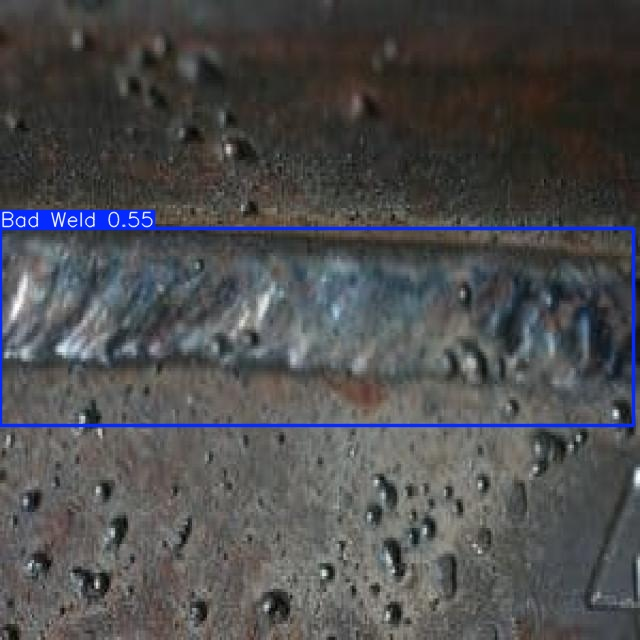


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/porosity-worm-hole-weld-defect-welding-process-flux-cored-arc-fcaw-204492534_jpeg_jpg.rf.c5201d1c888e3ffa1fded39930503d32.jpg: 640x640 1 Bad Weld, 3 Defects, 34.3ms
Speed: 2.5ms preprocess, 34.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


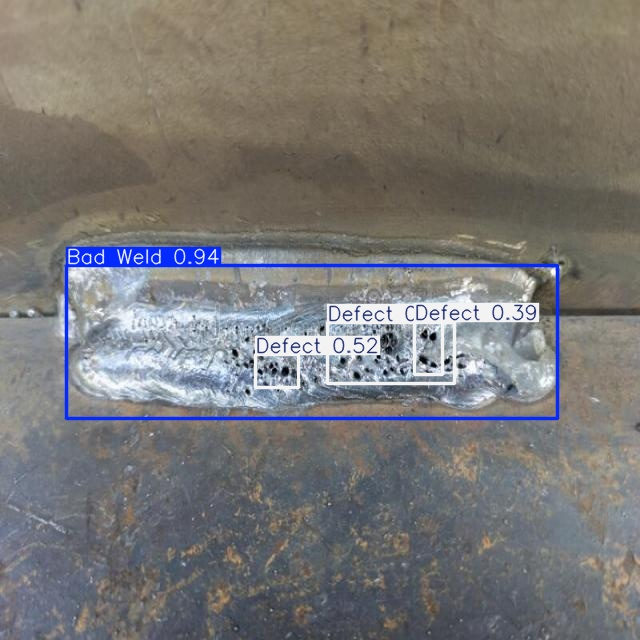


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/295992d6-f617b725-c1_png_jpg.rf.5f645e13f1695df588b0644ca9702c43.jpg: 640x640 1 Bad Weld, 32.7ms
Speed: 1.3ms preprocess, 32.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


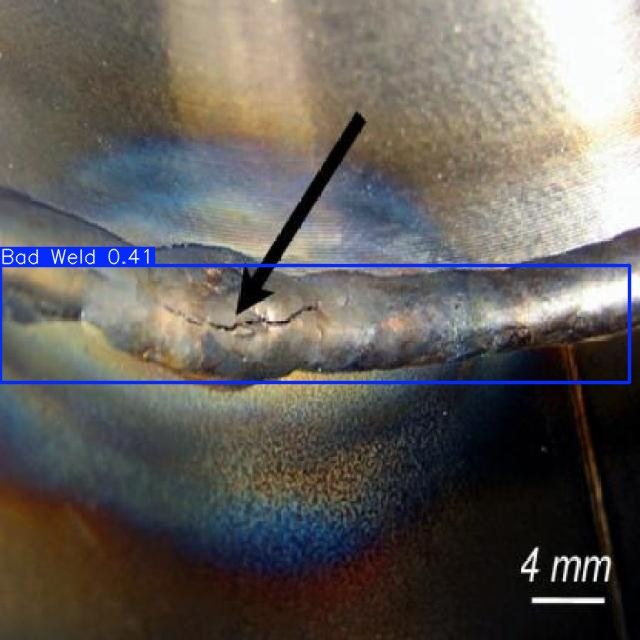


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good_weld_vid529_jpeg_jpg.rf.4dc697dcd18f7c7de001311bb1f845e6.jpg: 640x640 1 Good Weld, 32.6ms
Speed: 1.3ms preprocess, 32.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


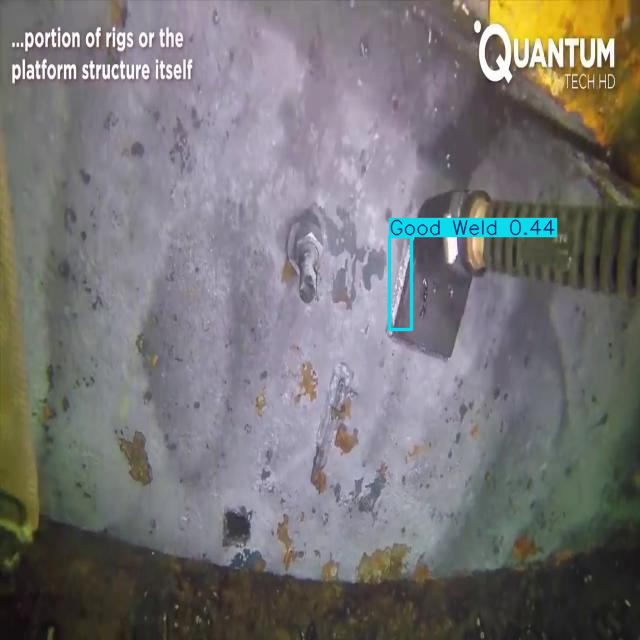


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset/The Welding Defect Dataset/test/images/1aa4b44c-d01b8a11-Hot-crack_jpg.rf.57393ca7936f061ca5991481b2b5c485.jpg: 640x640 1 Defect, 32.1ms
Speed: 1.3ms preprocess, 32.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


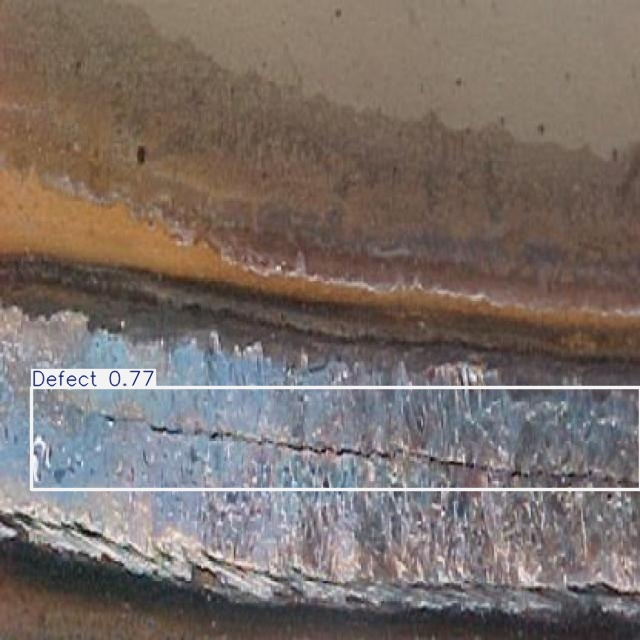

Displaying results from model trained on version 2 with augmentation:

image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/bad_weld_vid84_jpeg_jpg.rf.f148c4898a835b73a3eb087d905ed8f3.jpg: 640x640 1 Good Weld, 22.3ms
Speed: 1.6ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


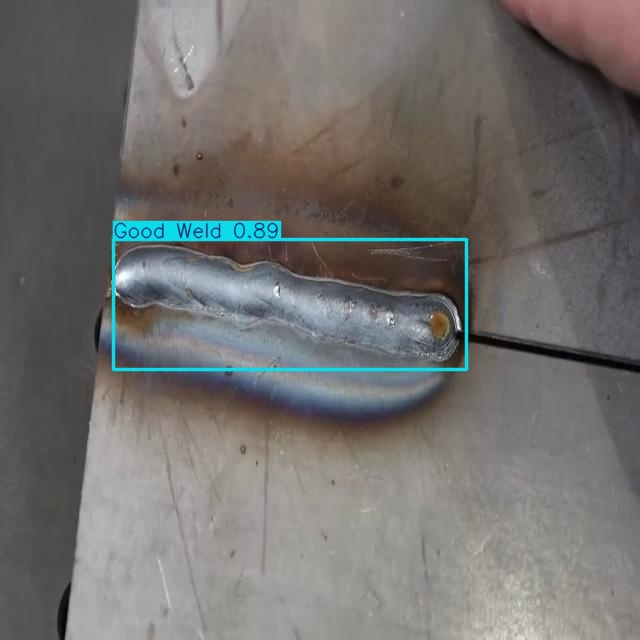


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/SampleV2_1_mp4-60_jpg.rf.40f4a4094130e65b1a801b49fefc5d01.jpg: 640x640 2 Bad Welds, 2 Good Welds, 1 Defect, 22.2ms
Speed: 1.4ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


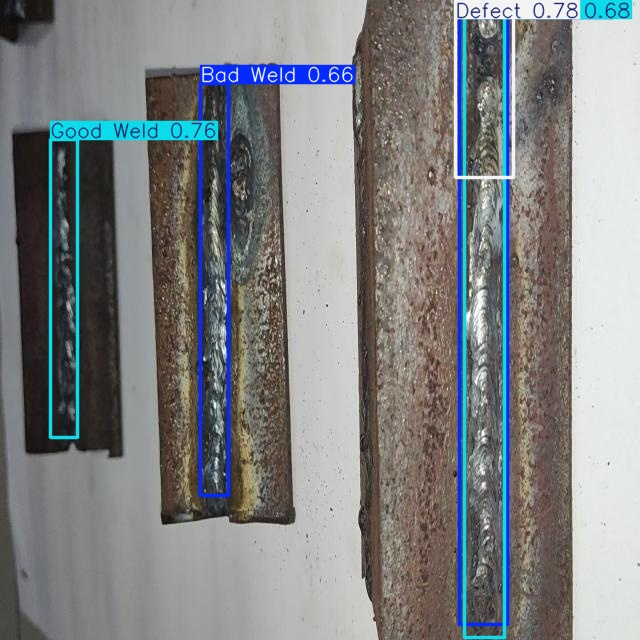


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-tig-welds_3_jpeg.rf.c6afd4c75c9f0f8866e1d58bb2a2ae0d.jpg: 640x640 2 Good Welds, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


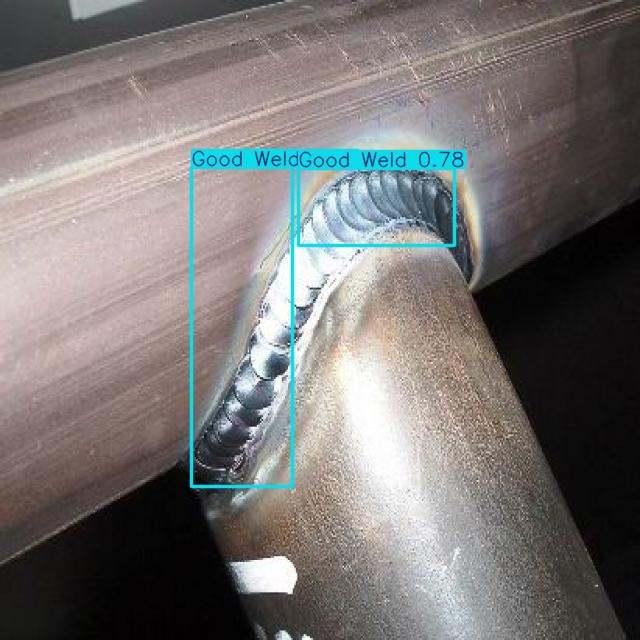


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/bad_weld_vid397_jpeg_jpg.rf.6aacbe170c5956e56b1024f24d60c60c.jpg: 640x640 1 Bad Weld, 1 Good Weld, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


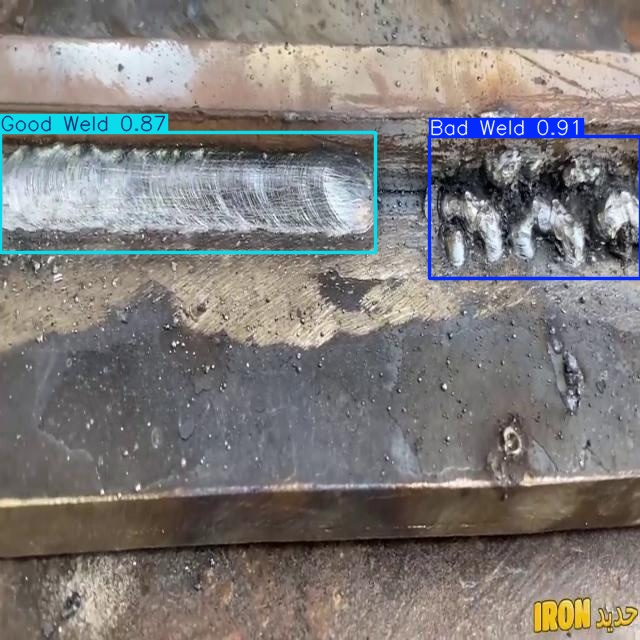


image 1/1 /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/crack-welding-images_17_jpeg_jpg.rf.ff570716da313da84983bc629ae7e331.jpg: 640x640 1 Bad Weld, 1 Defect, 22.4ms
Speed: 1.3ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


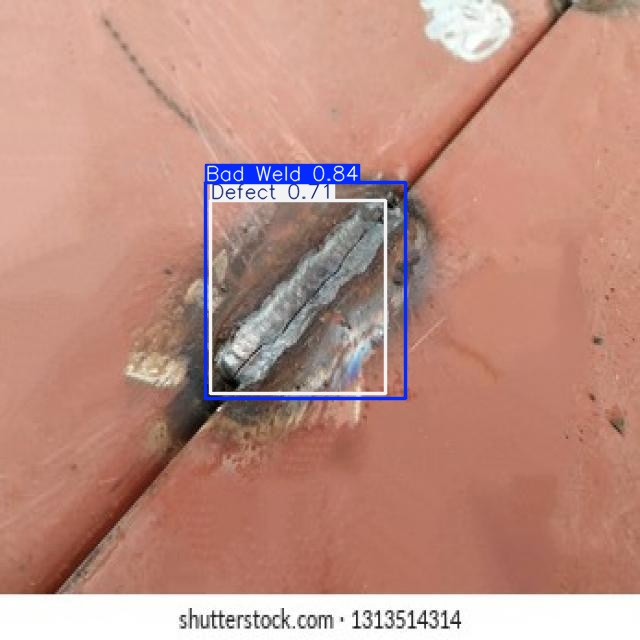

In [13]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model_v1, os.path.join(v1_dir, 'test/images'))

print("Displaying results from model trained on version 2 with augmentation:")
display_results(model_v2, os.path.join(v2_dir, 'test/images'))
